In [1]:
import numpy as np
import pandas as pd
import anndata
import pytorch_lightning as pl

In [2]:
from pipeline import read_mtx, qc, normalize

In [5]:
DATA_DIR = '/home/tiankang/wusuowei/data/single_cell/babel/snareseq_GSE126074/'
DATA_DIR_NCBI = '/home/tiankang/wusuowei/data/ncbi/'

In [16]:
X = read_mtx(DATA_DIR + 'GSE126074_AdBrainCortex_SNAREseq_cDNA.counts.mtx.gz')
print(X.shape)
X, good_genes, good_cells = qc(X, gene_min_cells=50, gene_min_counts=100, logic='mine')
good_genes.sum()

(10309, 33160)


13183

In [21]:
snare_gene = pd.read_csv(DATA_DIR + 'GSE126074_AdBrainCortex_SNAREseq_cDNA.genes.tsv.gz', sep='\t', header=None, squeeze=True)

In [22]:
snare_gene

0        0610005C13Rik
1        0610007P14Rik
2        0610009B22Rik
3        0610009E02Rik
4        0610009L18Rik
             ...      
33155       Vmn2r-ps83
33156          Vmn2r50
33157           Vpreb2
33158          n-R5s32
33159          n-R5s50
Name: 0, Length: 33160, dtype: object

In [28]:
snare_gene.is_unique

True

In [65]:
gene_df = pd.read_csv(DATA_DIR_NCBI + 'human.tsv', sep='\t', dtype={'chromosome': 'str'}).drop_duplicates(subset='Symbol')

In [68]:
gene_df.GeneID.is_unique

True

In [41]:
gene2go_df = pd.read_csv(DATA_DIR_NCBI + 'gene2go', sep='\t')
gene2go_df = gene2go_df[gene2go_df['#tax_id'] == 9606]
print(len(gene2go_df))
n2a = dict()

for name, group in gene2go_df.groupby('Category'):
    print(name)
    gene2go_dict = dict()
    gene2go = group[['GeneID', 'GO_ID']]
    for gene_id, go_group in gene2go.groupby('GeneID'):
        gene2go_dict[gene_id] = go_group.GO_ID
    if name == 'Component':
        n2a['CC'] = gene2go_dict
    elif name == 'Function':
        n2a['MF'] = gene2go_dict
    elif name == 'Process':
        n2a['BP'] = gene2go_dict
    else:
        raise NotImplementedError(name)


341938
Component
Function
Process


In [59]:
gene2go_df.GO_ID.unique().shape, gene2go_df.GeneID.unique().shape

((18637,), (20680,))

In [39]:
for k, v in n2a.items():
    print(k, len(v))

CC 19527
MF 18364
BP 18886


In [46]:
from tqdm.auto import tqdm

In [50]:
go_terms

array(['GO:0003674'], dtype=object)

In [52]:
n2a_all = {}
for k, v in n2a.items():
    for gene_id, go_terms in tqdm(v.items()):
        go_terms = go_terms.unique()
        if gene_id not in n2a_all:
            n2a_all[gene_id] = go_terms
        else:
            n2a_all[gene_id] = np.concatenate([n2a_all[gene_id], go_terms])

In [55]:
len(n2a_all)

20680

In [87]:
'pisd' in gene_df.Symbol.str.lower()

False

In [85]:
snare_gene[good_genes].str.lower().value_counts().sort_values(ascending=False)

pisd             2
bnc2             1
lyn              1
nudcd3           1
dnah7a           1
                ..
zfp930           1
4921539h07rik    1
lrrc16b          1
gm43582          1
slc7a15          1
Name: 0, Length: 13182, dtype: int64

In [82]:
gene_df.Symbol.str.lower().is_unique

True

In [83]:
gene_df.Symbol.str.lower().isin(snare_gene[good_genes].str.lower()).sum()

10464

In [93]:
good_gene1 = snare_gene[good_genes][snare_gene[good_genes].str.lower().isin(gene_df.Symbol.str.lower())].str.lower()
good_gene2 = gene_df.Symbol[gene_df.Symbol.str.lower().isin(snare_gene[good_genes].str.lower())].str.lower()

In [96]:
good_gene1.shape, good_gene2.shape, good_gene1.is_unique, good_gene2.is_unique

((10465,), (10464,), False, True)

In [104]:
gene_df.Symbol.str.lower().is_unique

True

In [112]:
dict(zip((1,2), (3,4)))

{1: 3, 2: 4}

In [113]:
name2id = dict(zip(gene_df.Symbol.str.lower(), gene_df.GeneID))

In [116]:
good_geneid = list(map(lambda name: name2id[name], good_gene1))

In [118]:
len(good_geneid)

10465

In [119]:
len([id_ for id_ in good_geneid if id_ in n2a_all])

10328

In [135]:
gene2go_df = pd.read_csv(DATA_DIR_NCBI + 'gene2go', sep='\t')
gene2go_df = gene2go_df[gene2go_df['#tax_id'] == 9606]

In [134]:
sizes = gene2go_df.groupby(['GeneID', 'GO_ID']).size()
sizes.iloc[sizes.argmax():sizes.argmax()+1]

GeneID  GO_ID     
650     GO:0030509    8
dtype: int64

<AxesSubplot:ylabel='Frequency'>

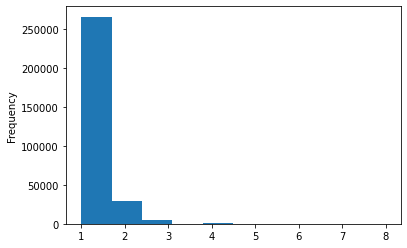

In [137]:
sizes.plot(kind='hist')

In [136]:
gene2go_df.query('GeneID == 650 & GO_ID == "GO:0030509"')

,#tax_id,GeneID,GO_ID,Evidence,Qualifier,GO_term,PubMed,Category
656804,9606,650,GO:0030509,IBA,involved_in,BMP signaling pathway,21873635,Process
656805,9606,650,GO:0030509,IDA,involved_in,BMP signaling pathway,16049014|18436533|20843790,Process
656806,9606,650,GO:0030509,IEP,involved_in,BMP signaling pathway,16194878,Process
656807,9606,650,GO:0030509,IGI,involved_in,BMP signaling pathway,22450430,Process
656808,9606,650,GO:0030509,IMP,acts_upstream_of_or_within,BMP signaling pathway,17472960,Process
656809,9606,650,GO:0030509,IMP,involved_in,BMP signaling pathway,18326817|19664780,Process
656810,9606,650,GO:0030509,ISS,involved_in,BMP signaling pathway,-,Process
656811,9606,650,GO:0030509,TAS,involved_in,BMP signaling pathway,-,Process


In [138]:
from train import Net

In [139]:
CHECKPOINT = '/home/tiankang/wusuowei/deeplearning/single_cell/denoise/lightning_logs/version_65/checkpoints/epoch=49-step=12899.ckpt'

In [140]:
model = Net.load_from_checkpoint(CHECKPOINT)

In [148]:
model.model.encoder[0].model[0].weight.shape

torch.Size([128, 13183])

<AxesSubplot:ylabel='Frequency'>

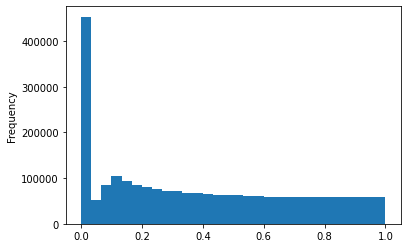

In [3]:
p = np.load('./data/p.npy')
pd.Series(p.flatten()).plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

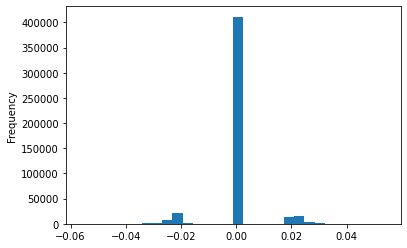

In [4]:
sim = np.load('./data/sim.npy')
sim = sim[p < 0.05]
pd.Series(sim.flatten()).plot(kind='hist', bins=30)

<AxesSubplot:ylabel='Frequency'>

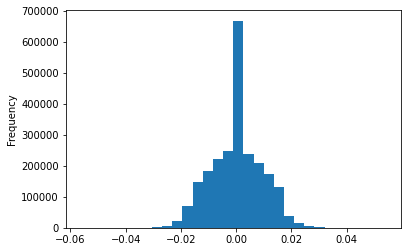

In [5]:
sim = np.load('./data/sim.npy')
pd.Series(sim.flatten()).plot(kind='hist', bins=30)